In [1]:
import os
import gc
import sys
import keras
import torch
import random
import numpy as np
import tensorflow as tf
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import train_test_split

sys.path.append(str(Path().resolve().parent))

from src.data_loader import load_NMR_dataset
from src.arch import DeepEntropy, masked_loss

d:\TUM\protein_prediction\DeepEntropy\de_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_nmr = load_NMR_dataset(filter="moderate")
moderate_nmr_ids = [ele["ID"] for ele in data_nmr]

In [3]:
# loading embedding

nmr_data = torch.load(Path().resolve().parent / "data/embeddings/nmr_merged.pt")

nmr_embeddings = []
nmr_plddt = []
nmr_gscores = []
nmr_gscores_masks = []


for nmr_ele in nmr_data:
    if nmr_ele["ID"] in moderate_nmr_ids:
        emb = nmr_ele["embedding"].numpy()  # shape: (L, 1024)
        plddt = np.array(nmr_ele["plddt"], dtype=np.float32)  # shape: (L,)
        
        raw_gscores = nmr_ele["gscores"]
        mask = np.array([v is not None for v in raw_gscores], dtype=bool)
        cleaned_gscores = np.array([0.0 if v is None else v for v in raw_gscores], dtype=np.float32)

        if emb.shape[0] != plddt.shape[0] or emb.shape[0] != len(cleaned_gscores):
            print("Unmatching dimension!")
            continue

        if sum(mask)/len(mask) > 0.8:
            nmr_embeddings.append(emb)
            nmr_plddt.append(plddt)
            nmr_gscores.append(cleaned_gscores)
            nmr_gscores_masks.append(mask)


In [4]:
print(len(nmr_embeddings))

627


In [5]:
disprot_data = torch.load(Path().resolve().parent / "data/embeddings/disprot_merged.pt")

disprot_embeddings = []
disprot_plddt = []
disprot_disorder_values = []

for idx, disprot_ele in enumerate(disprot_data):
    try:
        emb = disprot_ele["embedding"].numpy()  # shape: (L, 1024)
        plddt = np.array(disprot_ele["plddt"], dtype=np.float32)  # shape: (L,)
        disorder_value = np.array([disprot_ele["disorder_content"]], dtype=np.float32)  # scalar

        # Shape checks
        if emb.shape[0] != plddt.shape[0]:
            print(f"[{idx}] Shape mismatch: embedding L={emb.shape[0]}, plddt L={plddt.shape[0]}")
            continue
        if emb.shape[1] != 1024:
            print(f"[{idx}] Invalid embedding dim: got {emb.shape[1]}, expected 1024")
            continue
        
        disprot_embeddings.append(emb)
        disprot_plddt.append(plddt)
        disprot_disorder_values.append(disorder_value)

    except Exception as e:
        print(f"[{idx}] Error loading sample: {e}")

In [6]:
print(len(disprot_embeddings))

1620


In [7]:
softDis_data = torch.load(Path().resolve().parent / "data/embeddings/softdis_merged.pt")

softDis_embeddings = []
softDis_plddt = []
softDis_disorder_values = []

for idx, softDis_ele in enumerate(softDis_data):
    try:
        emb = softDis_ele["embedding"].numpy()  # shape: (L, 1024)
        plddt = np.array(softDis_ele["plddt"], dtype=np.float32)  # shape: (L,)
        disorder = np.array(softDis_ele["soft_disorder_frequency"], dtype=np.float32)  # shape: (L,)

        # Shape checks
        if emb.shape[1] != 1024:
            print(f"[{idx}] Invalid embedding dimension: got {emb.shape[1]}, expected 1024")
            continue
        if emb.shape[0] != plddt.shape[0] or emb.shape[0] != disorder.shape[0]:
            print(f"[{idx}] Length mismatch: embedding L={emb.shape[0]}, plddt L={plddt.shape[0]}, disorder L={disorder.shape[0]}")
            continue

        softDis_embeddings.append(emb)
        softDis_plddt.append(plddt)
        softDis_disorder_values.append(disorder)

    except Exception as e:
        print(f"[{idx}] Error loading sample: {e}")

[1714] Length mismatch: embedding L=1038, plddt L=1033, disorder L=1038
[2755] Length mismatch: embedding L=549, plddt L=571, disorder L=549
[2981] Length mismatch: embedding L=644, plddt L=645, disorder L=644
[3650] Length mismatch: embedding L=488, plddt L=221, disorder L=488


In [8]:
print(len(softDis_embeddings))

4068


In [9]:
# temporarily reducing sample size that the CPU can handle, later with larger compute instance run on all data

# nmr_embeddings = nmr_embeddings[:10]
# nmr_plddt = nmr_plddt[:10]
# nmr_gscores = nmr_gscores[:10]

# disprot_embeddings = disprot_embeddings[:10]
# disprot_plddt = disprot_plddt[:10]
# disprot_disorder_values = disprot_disorder_values[:10]

# softDis_embeddings = softDis_embeddings[:10]
# softDis_plddt = softDis_plddt[:10]
# softDis_disorder_values = softDis_disorder_values[:10]

In [10]:

disprot_masks = [np.ones_like(plddt, dtype=bool) for plddt in disprot_plddt]
softDis_masks = [np.ones_like(plddt, dtype=bool) for plddt in softDis_plddt]
combined_data = []

for idx in range(len(nmr_embeddings)):
    combined_data.append((
        nmr_embeddings[idx],
        nmr_plddt[idx] / 100,
        nmr_gscores[idx],
        nmr_gscores_masks[idx],
        "g_scores"
    ))

for idx in range(len(disprot_embeddings)):
    combined_data.append((
        disprot_embeddings[idx],
        disprot_plddt[idx] / 100,
        disprot_disorder_values[idx],
        disprot_masks[idx],
        "disprot_disorder"
    ))

for idx in range(len(softDis_embeddings)):
    combined_data.append((
        softDis_embeddings[idx],
        softDis_plddt[idx] / 100,
        softDis_disorder_values[idx],
        softDis_masks[idx],
        "softdis_disorder"
    ))

random.seed(42)
random.shuffle(combined_data)


### Train-Validation-Test split

In [11]:
labels = [entry[-1] for entry in combined_data]

train_val, test_data = train_test_split(
    combined_data,
    test_size=0.10,
    random_state=42,
    stratify=labels
)

train_data, val_data = train_test_split(
    train_val,
    test_size=2/9,
    random_state=42,
    stratify=[entry[-1] for entry in train_val]
)

print(f"total: {len(combined_data)}")
print(f"train: {len(train_data)} ({len(train_data)/len(combined_data):.2%})")
print(f"val: {len(val_data)} ({len(val_data)/len(combined_data):.2%})")
print(f"test: {len(test_data)} ({len(test_data)/len(combined_data):.2%})")

total: 6315
train: 4420 (69.99%)
val: 1263 (20.00%)
test: 632 (10.01%)


In [12]:
entropy = DeepEntropy()
print(entropy.encoder.summary())
print(entropy.nmr_head_model.summary())
print(entropy.DisProt_head_model.summary())
print(entropy.softdis_head_model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ embeddings          │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ plddt (InputLayer)  │ (None, None, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, None, 64)  │    196,672 │ embeddings[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, None, 64)  │        256 │ plddt[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, None, 32)  │      6,176 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, None, 32)  │      6,176 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, None, 16)  │      1,552 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, None, 16)  │      1,552 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, None, 8)   │        392 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, None, 8)   │        392 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 16)  │          0 │ conv1d_3[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_7[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 213,168 (832.69 KB)

 Trainable params: 213,168 (832.69 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ combined_features (InputLayer)  │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 64)       │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_scores (Dense)                │ (None, None, 1)        │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ combined_features (InputLayer)  │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 64)       │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, None, 64)       │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, None, 32)       │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disorder_content (Dense)        │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ combined_features (InputLayer)  │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, None, 64)       │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, None, 64)       │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, None, 32)       │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ soft_disorder_frequency (Dense) │ (None, None, 1)        │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [13]:
EPOCHS = 100
LEARNING_RATE = 0.005

In [14]:

# Compile the model
entropy.compile(
    NMR_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    DisProt_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    SoftDis_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    NMR_head_loss_fn = keras.losses.MeanSquaredError(),
    DisProt_head_loss_fn = keras.losses.MeanSquaredError(),
    SoftDis_head_loss_fn = keras.losses.MeanSquaredError()
)
entropy.run_eagerly = True

In [15]:
input_embeddings, input_plddt, _, _, _ = train_data[0]
entropy.build_init(
    embedding_shape = (1, input_embeddings.shape[0], input_embeddings.shape[1]), 
    plddt_shape = (1, input_plddt.shape[0])
)

All the heads and optimizers are initialized. Good luck with the training loop!


In [ ]:
timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_mse_ln_dropout_all")
dir_path = f"{str(Path().resolve().parent)}/data/models/{timestamp}"
os.makedirs(dir_path, exist_ok=True)

In [ ]:
with open(os.path.join(dir_path, "model_config.json"), 'w') as f:
    f.write(entropy.to_json())
    
with open(os.path.join(dir_path, "encoder.json"), 'w') as json_file:
    json_file.write(entropy.encoder.to_json())

with open(os.path.join(dir_path, "nmr_head.json"), 'w') as json_file:
    json_file.write(entropy.nmr_head_model.to_json())

with open(os.path.join(dir_path, "disprot_head.json"), 'w') as json_file:
    json_file.write(entropy.DisProt_head_model.to_json())

with open(os.path.join(dir_path, "softdis_head.json"), 'w') as json_file:
    json_file.write(entropy.softdis_head_model.to_json())

In [17]:

nmr_loss_per_epoc = []
disprot_loss_per_epoc = []
softdis_loss_per_epoc = []

nmr_loss_per_sample_total = []
disprot_loss_per_sample_total = []
softdis_loss_per_sample_total = []

val_nmr_losses_per_epoc = []
val_disprot_losses_per_epoc = []
val_softdis_losses_per_epoc = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}")
    random.shuffle(train_data)

    nmr_loss, disprot_loss, softdis_loss = [], [], []

    for input_embeddings, input_plddt, target, mask, task_flag in train_data:
        entropy.target_flag_ = task_flag

        # Convert to tensors and expand dims
        input_embeddings_tf = tf.convert_to_tensor(input_embeddings[np.newaxis, ...], dtype=tf.float32)
        input_plddt_tf = tf.convert_to_tensor(input_plddt[np.newaxis, ...], dtype=tf.float32)
        target_tf = tf.convert_to_tensor(target[np.newaxis, ...], dtype=tf.float32)
        mask_tf = tf.convert_to_tensor(mask[np.newaxis, ...], dtype=tf.bool)

        # Call model
        # data = (input_embeddings_tf, input_plddt_tf, target_tf, mask_tf)
        # history = entropy.fit(data)
        # loss = history.history['loss'][0]
        # print(f"{task_flag} head : epoch {epoch + 1}")

        data = (input_embeddings_tf, input_plddt_tf, target_tf, mask_tf)
        loss = entropy.train_on_batch(data, return_dict=True)

        # Save loss per task
        if task_flag == "g_scores":
            nmr_head_loss = loss["NMR_head_loss"]
            print(f"{task_flag} head : epoch {epoch + 1} : loss {nmr_head_loss}")
            nmr_loss.append(nmr_head_loss)
        elif task_flag == "disprot_disorder":
            disprot_head_loss = loss["DisProt_head_loss"]
            print(f"{task_flag} head : epoch {epoch + 1} : loss {disprot_head_loss}")
            disprot_loss.append(disprot_head_loss)
        else:
            softdis_head_loss = loss["SoftDis_head_loss"]
            print(f"{task_flag} head : epoch {epoch + 1} : loss {softdis_head_loss}")
            softdis_loss.append(softdis_head_loss)

    # Save average losses per epoch
    nmr_loss_per_epoc.append(sum(nmr_loss) / len(nmr_loss) if nmr_loss else None)
    disprot_loss_per_epoc.append(sum(disprot_loss) / len(disprot_loss) if disprot_loss else None)
    softdis_loss_per_epoc.append(sum(softdis_loss) / len(softdis_loss) if softdis_loss else None)

    nmr_loss_per_sample_total.extend(nmr_loss)
    disprot_loss_per_sample_total.extend(disprot_loss)
    softdis_loss_per_sample_total.extend(softdis_loss)

    # Validation
    val_nmr_losses = []
    val_disprot_losses = []
    val_softdis_losses = []

    for input_embeddings, input_plddt, target, mask, task_flag in val_data:
        entropy.target_flag_ = task_flag

        input_embeddings_tf = tf.convert_to_tensor(input_embeddings[np.newaxis, ...], dtype=tf.float32)
        input_plddt_tf = tf.convert_to_tensor(input_plddt[np.newaxis, ...], dtype=tf.float32)
        target_tf = tf.convert_to_tensor(target[np.newaxis, ...], dtype=tf.float32)
        mask_tf = tf.convert_to_tensor(mask[np.newaxis, ...], dtype=tf.bool)

        data = (input_embeddings_tf, input_plddt_tf)
        prediction = entropy.predict(data)

        if task_flag == "g_scores":
            loss = entropy.NMR_head_loss_fn(target_tf, prediction, mask_tf)
            val_nmr_losses.append(loss)

        elif task_flag == "disprot_disorder":
            loss = entropy.DisProt_head_loss_fn(target_tf, prediction)
            val_disprot_losses.append(loss)

        else:
            loss = entropy.SoftDis_head_loss_fn(target_tf, prediction)
            val_softdis_losses.append(loss)

    val_nmr_losses_per_epoc.append(sum(val_nmr_losses) / len(val_nmr_losses) if val_nmr_losses else 0)
    val_disprot_losses_per_epoc.append(sum(val_disprot_losses) / len(val_disprot_losses) if val_disprot_losses else 0)
    val_softdis_losses_per_epoc.append(sum(val_softdis_losses) / len(val_softdis_losses) if val_softdis_losses else 0)


    entropy.encoder.save_weights(os.path.join(dir_path, "encoder.weights.h5"))
    entropy.nmr_head_model.save_weights(os.path.join(dir_path, "nmr_head.weights.h5"))
    entropy.DisProt_head_model.save_weights(os.path.join(dir_path, "disProt_head.weights.h5"))
    entropy.softdis_head_model.save_weights(os.path.join(dir_path, "softDis_head.weights.h5"))

    # clearing memory
    gc.collect()
    tf.keras.backend.clear_session()
    gc.collect()



Epoch 1
softdis_disorder head : epoch 1 : loss 0.27997416257858276
softdis_disorder head : epoch 1 : loss 0.40274330973625183
softdis_disorder head : epoch 1 : loss 0.32349979877471924
disprot_disorder head : epoch 1 : loss 0.049139492213726044
softdis_disorder head : epoch 1 : loss 0.33213353157043457
softdis_disorder head : epoch 1 : loss 0.286928653717041
softdis_disorder head : epoch 1 : loss 0.26021334528923035
softdis_disorder head : epoch 1 : loss 0.24808715283870697
disprot_disorder head : epoch 1 : loss 0.029923848807811737
softdis_disorder head : epoch 1 : loss 0.23539553582668304
softdis_disorder head : epoch 1 : loss 0.22005268931388855
softdis_disorder head : epoch 1 : loss 0.21258330345153809
softdis_disorder head : epoch 1 : loss 0.2065754383802414
softdis_disorder head : epoch 1 : loss 0.19848330318927765
disprot_disorder head : epoch 1 : loss 0.02085026167333126
softdis_disorder head : epoch 1 : loss 0.19037893414497375
g_scores head : epoch 1 : loss 0.241392955183982

KeyboardInterrupt: 

In [18]:
print(nmr_loss_per_epoc)
print(disprot_loss_per_epoc)
print(softdis_loss_per_epoc)

print(val_nmr_losses_per_epoc)
print(val_disprot_losses_per_epoc)
print(val_softdis_losses_per_epoc)

[np.float32(0.037080135), np.float32(0.03812921), np.float32(0.039562985), np.float32(0.039348986), np.float32(0.040324528), np.float32(0.04084287), np.float32(0.04253433), np.float32(0.042877216), np.float32(0.04386969), np.float32(0.044204418), np.float32(0.044485502)]
[np.float32(0.041659176), np.float32(0.040127657), np.float32(0.037000973), np.float32(0.035251394), np.float32(0.033166528), np.float32(0.03186883), np.float32(0.030451205), np.float32(0.028934157), np.float32(0.027798405), np.float32(0.02680956), np.float32(0.025785923)]
[np.float32(0.09207544), np.float32(0.08191043), np.float32(0.07902921), np.float32(0.07701439), np.float32(0.07526425), np.float32(0.073502086), np.float32(0.07183417), np.float32(0.07007581), np.float32(0.068381764), np.float32(0.06672559), np.float32(0.06511918)]
[<tf.Tensor: shape=(), dtype=float32, numpy=0.042635053396224976>, <tf.Tensor: shape=(), dtype=float32, numpy=0.04324053227901459>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0412226617

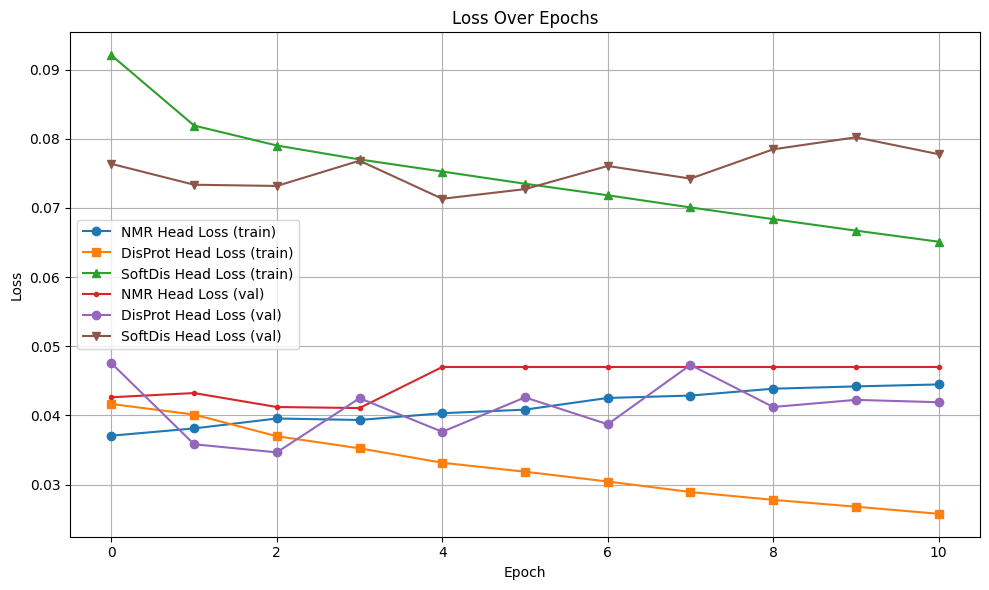

In [21]:
epochs = [i for i in range(len(disprot_loss_per_epoc))]

plt.figure(figsize=(10, 6))
plt.plot(epochs, nmr_loss_per_epoc, label='NMR Head Loss (train)', marker='o')
plt.plot(epochs, disprot_loss_per_epoc, label='DisProt Head Loss (train)', marker='s')
plt.plot(epochs, softdis_loss_per_epoc, label='SoftDis Head Loss (train)', marker='^')

plt.plot(epochs, val_nmr_losses_per_epoc, label='NMR Head Loss (val)', marker='.')
plt.plot(epochs, val_disprot_losses_per_epoc, label='DisProt Head Loss (val)', marker='o')
plt.plot(epochs, val_softdis_losses_per_epoc, label='SoftDis Head Loss (val)', marker='v')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
full_path = os.path.join(dir_path, "loss_curve_per_epochs_all.png")
plt.savefig(full_path)
plt.show()

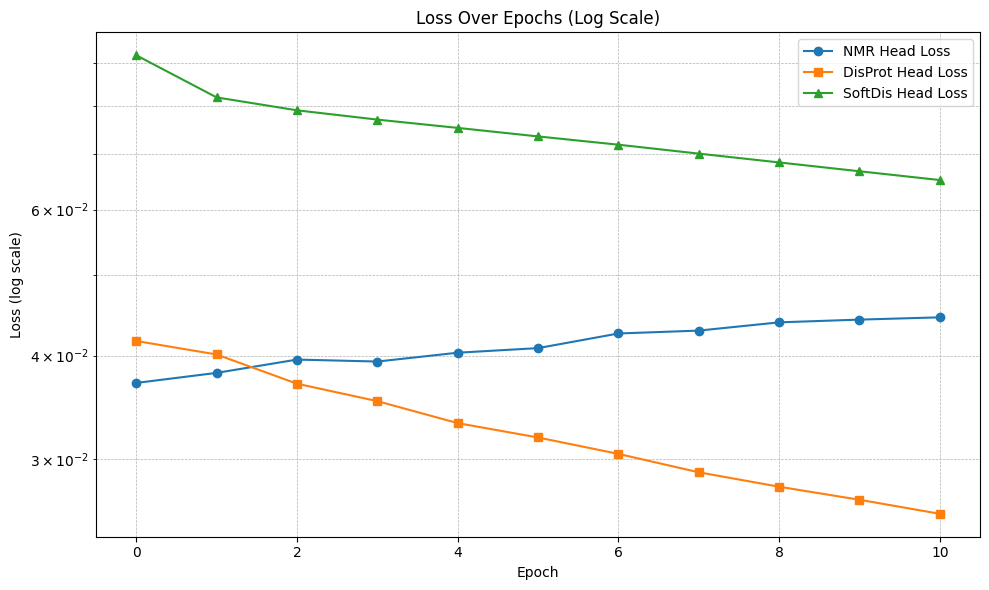

In [23]:
plt.figure(figsize=(10, 6))

plt.plot(epochs, nmr_loss_per_epoc, label='NMR Head Loss', marker='o')
plt.plot(epochs, disprot_loss_per_epoc, label='DisProt Head Loss', marker='s')
plt.plot(epochs, softdis_loss_per_epoc, label='SoftDis Head Loss', marker='^')

# plt.plot(epochs, val_nmr_losses_per_epoc, label='NMR Head Loss (val)', marker='.')
# plt.plot(epochs, val_disprot_losses_per_epoc, label='DisProt Head Loss (val)', marker='o')
# plt.plot(epochs, val_softdis_losses_per_epoc, label='SoftDis Head Loss (val)', marker='v')

plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.title("Loss Over Epochs (Log Scale)")
plt.yscale('log')  # Set y-axis to log scale
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
full_path = os.path.join(dir_path, "log_loss_curve_per_epochs_train.png")
plt.savefig(full_path)
plt.show()


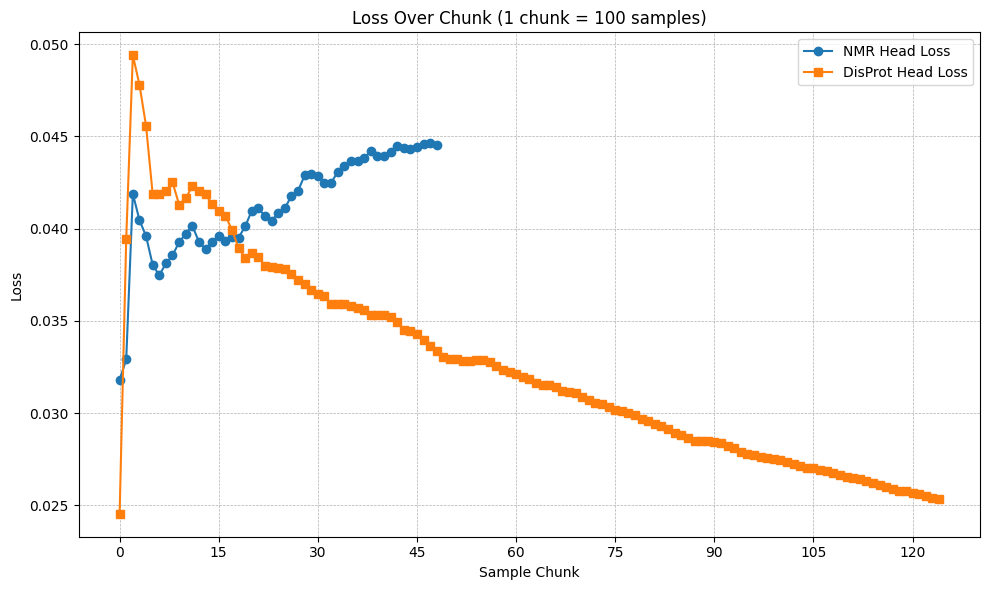

In [ ]:
chunk_size = 100
nmr_loss_per_sample_smooth = [
    sum(nmr_loss_per_sample_total[i:i+chunk_size]) / len(nmr_loss_per_sample_total[i:i+chunk_size])
    for i in range(0, len(nmr_loss_per_sample_total), chunk_size)
]
disprot_loss_per_sample_smooth = [
    sum(disprot_loss_per_sample_total[i:i+chunk_size]) / len(disprot_loss_per_sample_total[i:i+chunk_size])
    for i in range(0, len(disprot_loss_per_sample_total), chunk_size)
]
softdis_loss_per_sample_smooth = [
    sum(softdis_loss_per_sample_total[i:i+chunk_size]) / len(softdis_loss_per_sample_total[i:i+chunk_size])
    for i in range(0, len(softdis_loss_per_sample_total), chunk_size)
]


epochs = list(range(len(disprot_loss_per_sample_smooth)))

plt.figure(figsize=(10, 6))

plt.plot(range(len(nmr_loss_per_sample_smooth)), nmr_loss_per_sample_smooth, label='NMR Head Loss', marker='o')
plt.plot(range(len(disprot_loss_per_sample_smooth)), disprot_loss_per_sample_smooth, label='DisProt Head Loss', marker='s')
plt.plot(range(len(softdis_loss_per_sample_smooth)), softdis_loss_per_sample_smooth, label='SoftDis Head Loss', marker='^')

plt.xlabel("Sample Chunk")
plt.ylabel("Loss")
plt.title(f"Loss Over Chunk (1 chunk = {chunk_size} samples)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
full_path = os.path.join(dir_path, "loss_curve_per_sample_nmr_disprot.png")
plt.savefig(full_path)
plt.show()


### Prediction on Test Data

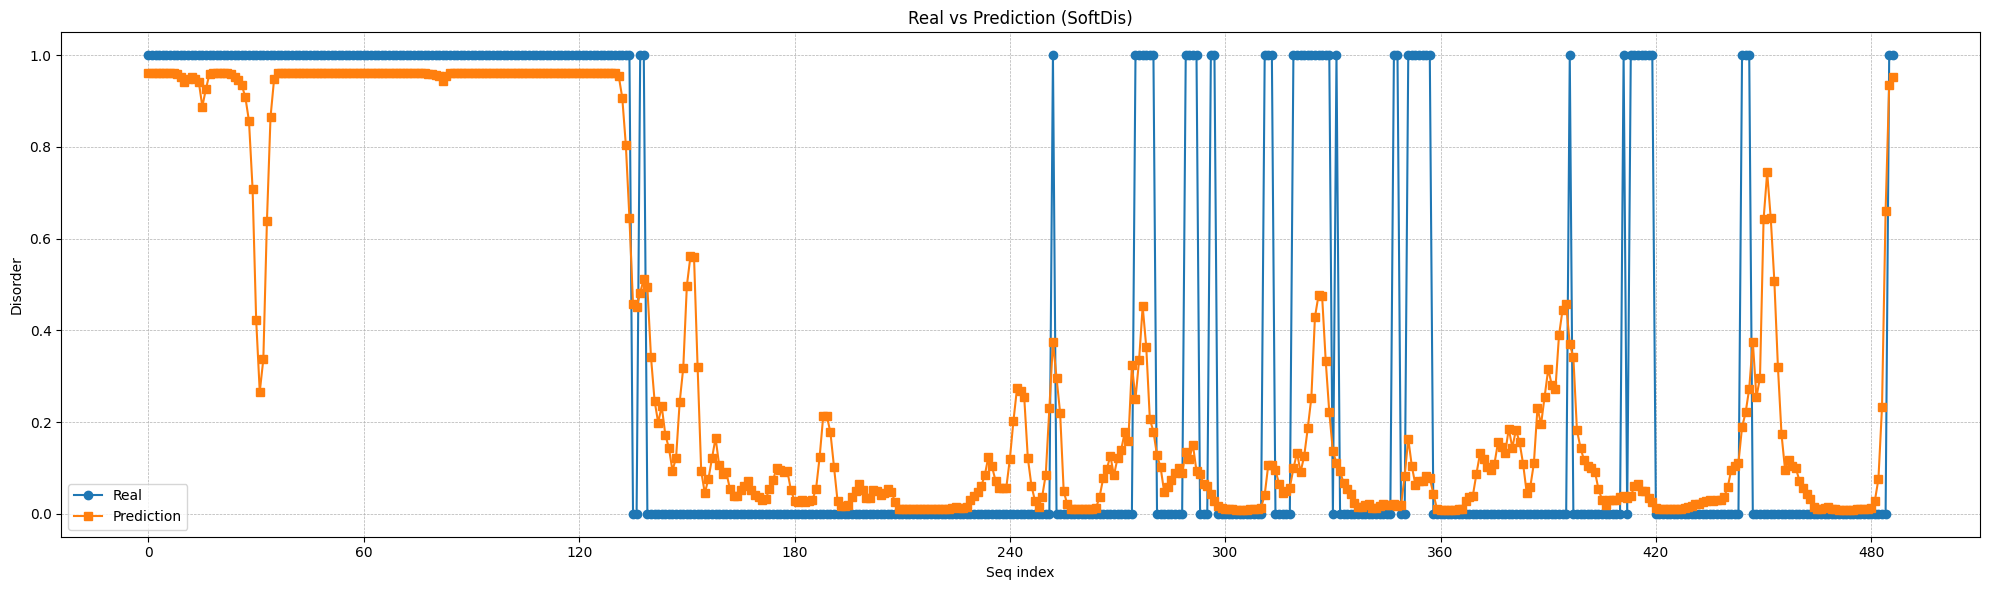

In [86]:
rand_idx = random.randint(1, 1000)
input_embeddings, input_plddt, target, mask, task_flag = test_data[rand_idx]
entropy.target_flag_ = task_flag

input_embeddings_tf = tf.convert_to_tensor(input_embeddings[np.newaxis, ...], dtype=tf.float32)
input_plddt_tf = tf.convert_to_tensor(input_plddt[np.newaxis, ...], dtype=tf.float32)
mask_tf = tf.convert_to_tensor(mask[np.newaxis, ...], dtype=tf.bool)

data = (input_embeddings_tf, input_plddt_tf)
prediction = entropy.predict(data).numpy().reshape(-1)
# target = target.numpy().reshape(target.shape[1])

# mask filtering
mask_np = mask.astype(bool)
target_filtered = target[mask_np]
prediction_filtered = prediction[mask_np]
seq_idx = [i for i in range(len(mask)) if mask[i]]

if task_flag == "softdis_disorder":
    plt.figure(figsize=(20, 6))
    plt.plot(seq_idx, target_filtered, label='Real', marker='o')
    plt.plot(seq_idx, prediction_filtered, label='Prediction', marker='s')

    plt.xlabel("Seq index")
    plt.ylabel("Disorder")
    plt.title("Real vs Prediction (SoftDis)")
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    full_path = os.path.join(dir_path, "real_vs_prediction_softDis_2.png")
    plt.savefig(full_path)
    plt.show()

elif task_flag == "g_scores":
    plt.figure(figsize=(20, 6))
    plt.plot(seq_idx, target_filtered, label='Real', marker='o')
    plt.plot(seq_idx, prediction_filtered, label='Prediction', marker='s')

    plt.xlabel("Seq index")
    plt.ylabel("Gscores")
    plt.title("Real vs Prediction (NMR)")
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    full_path = os.path.join(dir_path, "real_vs_prediction_nmr.png")
    plt.savefig(full_path)
    plt.show()

else:
    print(f"Real: {target}, prediction: {prediction}, difference: {abs(prediction-target)}")

In [68]:
# for idx, item in enumerate(train_data):
#     input_embeddings, input_plddt, target, _, task_flag = item
#     if task_flag == "g_scores":
#         print(idx)

In [60]:
all_target = []
all_prediction = []

for input_embeddings, input_plddt, target, _, task_flag in test_data:
    if task_flag == "disprot_disorder":
        input_embeddings_tf = tf.convert_to_tensor(input_embeddings[np.newaxis, ...], dtype=tf.float32)
        input_plddt_tf = tf.convert_to_tensor(input_plddt[np.newaxis, ...], dtype=tf.float32)

        entropy.target_flag_ = task_flag
        data = (input_embeddings_tf, input_plddt_tf)
        prediction = entropy.predict(data).numpy().reshape(-1)
        target = target[0]
        # target = target.numpy().reshape(target.shape[1])

        all_target.append(target)
        all_prediction.append(prediction)

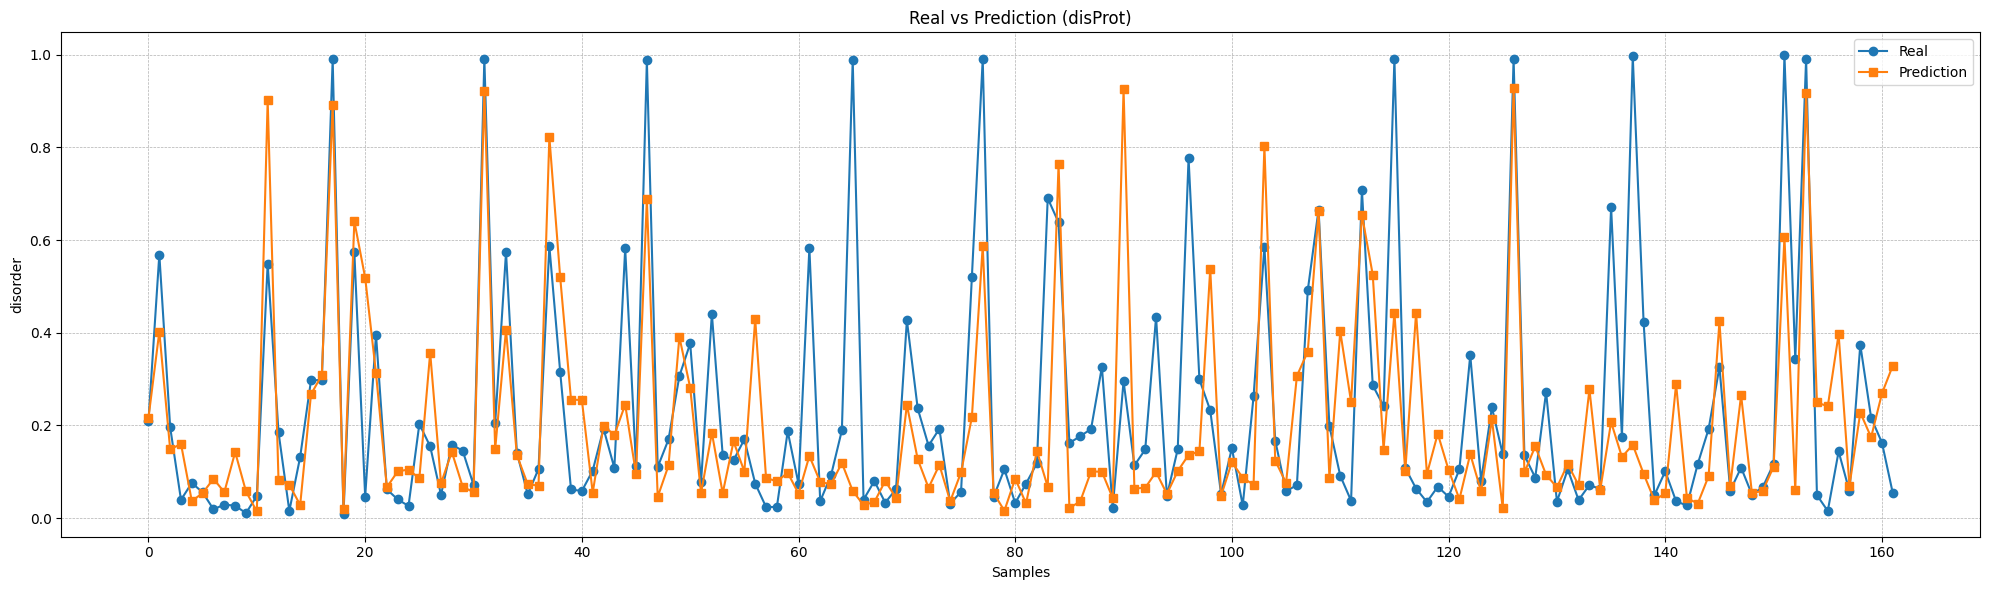

In [61]:
plt.figure(figsize=(20, 6))
seq_idx = [i for i in range(len(all_prediction))]
plt.plot(seq_idx, all_target, label='Real', marker='o')
plt.plot(seq_idx, all_prediction, label='Prediction', marker='s')

plt.xlabel("Samples")
plt.ylabel("disorder")
plt.title("Real vs Prediction (disProt)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
full_path = os.path.join(dir_path, "real_vs_prediction_disprot_train.png")
plt.savefig(full_path)
plt.show()